### Students
+ Carrascosa, Lucas
+ Gantos, Gabrielle
+ Igel, Alexander
+ Soto, Alberto
+ Stauffer, Raymond A.
+ Stela, Biel 

# Imports

In [1]:
import sys

# MacBook path
#sys.path.append('/Users/lucas/Dropbox/Lucas/Master_FDS/ML')

# Ubuntu path
sys.path.append('/home/lucas/Dropbox/Lucas/Master_FDS/ML')
#sys.path.append('/Users/user/Desktop/ML/project/')

from __future__ import division

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import math
import string

from IPython.display import HTML
from IPython.display import display

from sklearn import feature_selection
from sklearn import cross_validation
from sklearn import metrics
from sklearn import grid_search
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn import svm
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
def print_full(x, n=None, m=None):
    """
    Print a full pandas object.

    Args:
        x: dataframe or series
        n: max rows to show
        m: max columns to show
    """

    shape = x.shape
    pd.set_option('display.max_rows', n or shape[0])
    if (len(shape) > 1):
        pd.set_option('display.max_columns', m or shape[1])
    display(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')


def k_fold_cross_validation(X, y, k, clf, shuffle=True, random_state=None):
    
    # Determine the indices for each fold
    cv = cross_validation.KFold(X.shape[0], n_folds=k, shuffle=shuffle, random_state=random_state)
    
    # Initialize the score and yhat array
    score = np.zeros((X.shape[0],1))
    yhat = np.zeros((X.shape[0],1))
    
    # Cross validation
    for train_idx, test_idx in cv:
        X_train,y_train = X[train_idx,:], y[train_idx]
        X_test,y_test = X[test_idx,:], y[test_idx]

        scaler = StandardScaler()
        X_train_scaled=scaler.fit_transform(X_train)

        clf.fit(X_train_scaled,y_train)

        X_test_scaled = scaler.transform(X_test)

        score[test_idx] = clf.predict_proba(X_test_scaled)[:, 1].reshape(-1,1)
        yhat[test_idx] = clf.predict(X_test_scaled).reshape(-1,1)

    return score, yhat


def nested_k_fold_CV(X, y, k, n, clf_list, metric, shuffle=True, 
    random_state=None):
        
    # Initializing metric array
    metric_array = np.zeros((n, len(clf_list)))

    for i in xrange(len(clf_list)):

        for j in xrange(n):

            # K-fold cross validation
            score, yhat = k_fold_cross_validation(X, y, k, clf_list[i], 
                shuffle=shuffle, random_state=random_state)

            # Get metrics
            m = get_metrics(y, score, yhat)
            metric_array[j, i] = m[metric]
    
    return metric_array


def get_metrics(y, score, yhat):
    
    # Create a metrics dict
    metrics_dict = {}
    
    # Log loss
    metrics_dict['log_loss'] = metrics.log_loss(y, score)

    # Accuracy
    metrics_dict['accuracy'] = metrics.accuracy_score(y, yhat)

    # ROC AUC
    fpr, tpr, _ = metrics.roc_curve(y, score)
    metrics_dict['roc_auc'] = metrics.auc(fpr, tpr)
    
    return metrics_dict

<div class = "alert alert-danger" style = "border-radius:10px">**DELIVERABLE: ** Next day we will work on the problem of `Churn?`. Report the best classifier found and their metrics.
<p>
Some hints
<ol>
<li>Select one or two classifiers. Some of the most powerful classifiers are `Random Forests`, `SVM with RBF kernel`, and `extreme Gradient Boosting`.</li>
<li>Find out what parameters to validate. </li>
<li>Grid search and cross validate the problem.</li>
</ol>
</div>

The complete set of attributes is the following:

+ State: categorical, for the 50 states and the District of Columbia
+ Account length: integer-valued, how long an account has been active 
+ Area code: categorical
+ Phone number: customer ID
+ International Plan: binary feature, yes or no
+ VoiceMail Plan: binary feature, yes or no
+ Number of voice mail messages: integer-valued
+ Total day minutes: continuous, minutes customer used service during the day
+ Total day calls: integer-valued
+ Total day charge: continuous
+ Total evening minutes: continuous, minutes customer used service during the evening
+ Total evening calls: integer-valued
+ Total evening charge: continuous
+ Total night minutes: continuous, minutes customer used service during the night
+ Total night calls: integer-valued
+ Total night charge: continuous
+ Total international minutes: continuous, minutes customer used service to make international calls
+ Total international calls: integer-valued
+ Total international charge: continuous
+ Number of calls to customer service: integer-valued

# Load data and get info

In [3]:
# Load data
df = pd.read_csv('./files/churn.csv')
df['Area Code'] = df['Area Code'].astype(str)

In [4]:
# All columns' names and types
col_names = df.columns.tolist()

print "Column names:"
for col in col_names:
    print col, ' - ', df[col].dtype

# Header
print_full(df.head())

Column names:
State  -  object
Account Length  -  int64
Area Code  -  object
Phone  -  object
Int'l Plan  -  object
VMail Plan  -  object
VMail Message  -  int64
Day Mins  -  float64
Day Calls  -  int64
Day Charge  -  float64
Eve Mins  -  float64
Eve Calls  -  int64
Eve Charge  -  float64
Night Mins  -  float64
Night Calls  -  int64
Night Charge  -  float64
Intl Mins  -  float64
Intl Calls  -  int64
Intl Charge  -  float64
CustServ Calls  -  int64
Churn?  -  object


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [5]:
# Correlation matrix

df.corr()

,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
Account Length,1.000000,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796
VMail Message,-0.004628,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263
Day Mins,0.006216,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423
Day Calls,0.038470,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942
Day Charge,0.006214,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427
Eve Mins,-0.006757,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985
Eve Calls,0.019260,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423
Eve Charge,-0.006745,0.017578,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074,-0.012987
Night Mins,-0.008955,0.007681,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180,-0.009288
Night Calls,-0.013176,0.007123,0.022972,-0.019557,0.022972,0.007586,0.007710,0.007596,0.011204,1.000000,0.011188,-0.013605,0.000305,-0.013630,-0.012802


The ** Mins ** and ** Charge ** features are completely correlated with each other:
+ Day Mins & Day Charge
+ Eve Mins & Eve Charge
+ Night Mins & Night Charge
+ Intl Mins & Intl Charge

In [6]:
mins_features = ['Day Mins', 'Eve Mins', 'Night Mins', 'Intl Mins']
charge_features = ['Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge']

# Drop Mins / Charge features
df.drop(charge_features, axis=1, inplace=True)

# Categorical features

In [7]:
# Selecting categorical variables
categorical_v = [v for v in df.columns if df[v].dtype == object]
print 'Categorical variables:', categorical_v, '\n'

# Value counts
for v in categorical_v:
    print v, 'value counts:\n', df[v].value_counts(dropna=False), '\n'

Categorical variables: ['State', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'Churn?'] 

State value counts:
WV    106
MN     84
NY     83
AL     80
WI     78
OH     78
OR     78
WY     77
VA     77
CT     74
MI     73
ID     73
VT     73
TX     72
UT     72
IN     71
KS     70
MD     70
MT     68
NJ     68
NC     68
NV     66
WA     66
CO     66
MS     65
RI     65
MA     65
AZ     64
MO     63
FL     63
NM     62
ME     62
ND     62
DE     61
OK     61
NE     61
SC     60
SD     60
KY     59
IL     58
NH     56
AR     55
DC     54
GA     54
TN     53
HI     53
AK     52
LA     51
PA     45
IA     44
CA     34
Name: State, dtype: int64 

Area Code value counts:
415    1655
510     840
408     838
Name: Area Code, dtype: int64 

Phone value counts:
385-6952    1
405-5403    1
368-6174    1
353-7730    1
370-7565    1
346-6352    1
387-7371    1
384-1621    1
369-2625    1
372-3987    1
411-1530    1
417-4810    1
355-9581    1
383-9448    1
400-5751    1
344-9302    1
413-7743   

# Continuous features

In [8]:
# Selecting continuous variables
continuous_v = [v for v in df.columns if df[v].dtype != object]
print 'Categorical variables:', continuous_v, '\n'

Categorical variables: ['Account Length', 'VMail Message', 'Day Mins', 'Day Calls', 'Eve Mins', 'Eve Calls', 'Night Mins', 'Night Calls', 'Intl Mins', 'Intl Calls', 'CustServ Calls'] 



## Missing values detection

In [9]:
for v in continuous_v:
    print v, 'missing values:', df[v].isnull().sum()

Account Length missing values: 0
VMail Message missing values: 0
Day Mins missing values: 0
Day Calls missing values: 0
Eve Mins missing values: 0
Eve Calls missing values: 0
Night Mins missing values: 0
Night Calls missing values: 0
Intl Mins missing values: 0
Intl Calls missing values: 0
CustServ Calls missing values: 0


## Box plot, Histogram and Scatter plot

Account Length


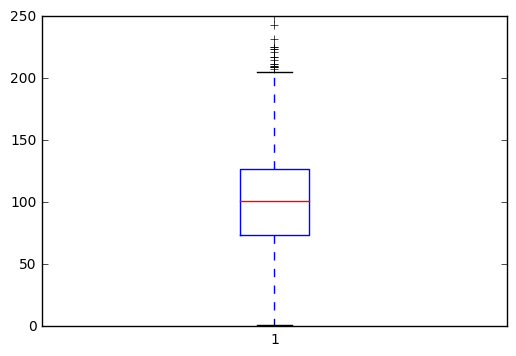

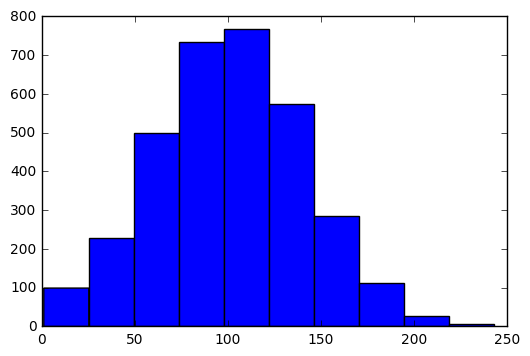

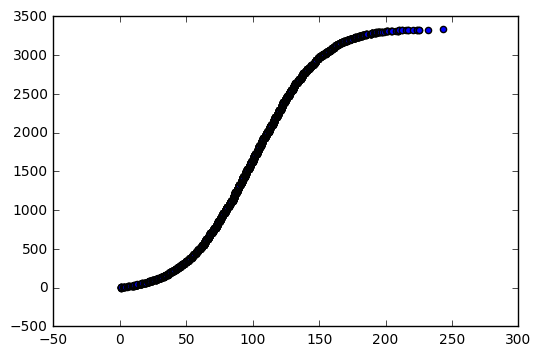



VMail Message


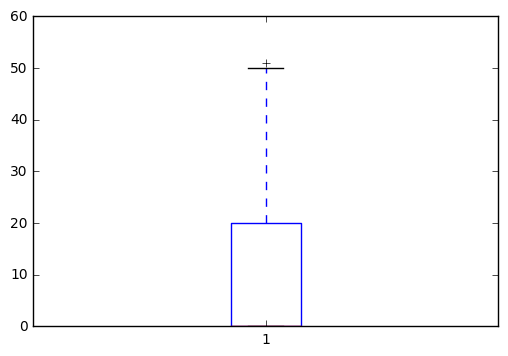

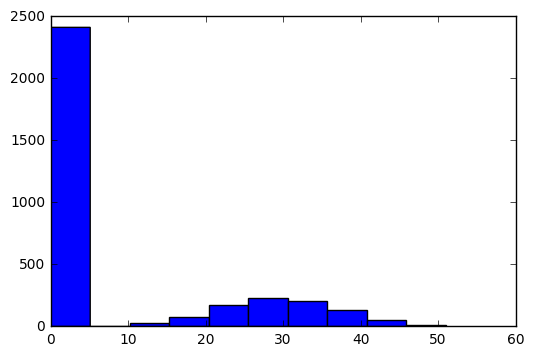

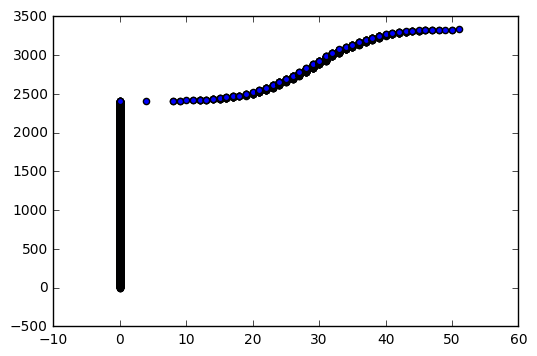



Day Mins


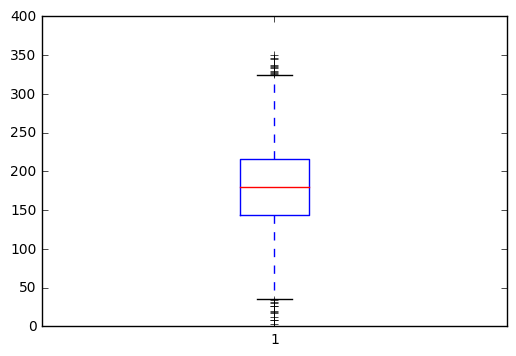

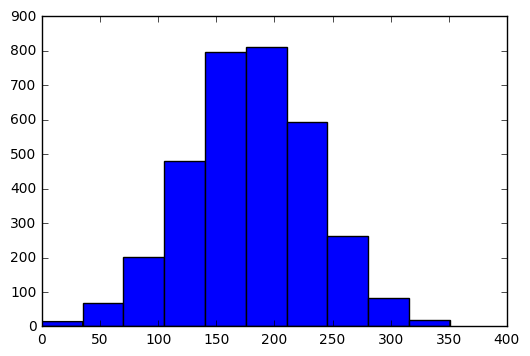

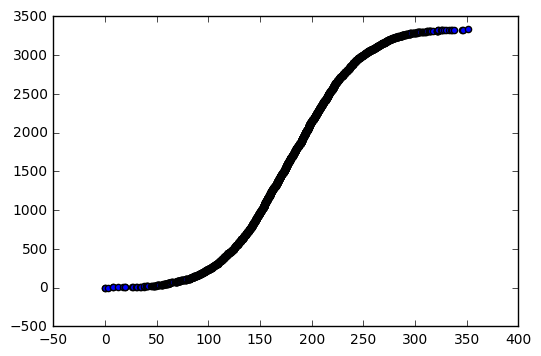



Day Calls


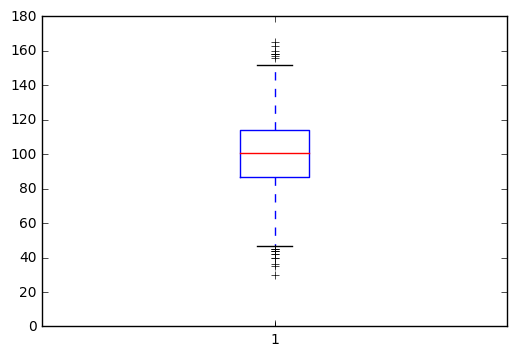

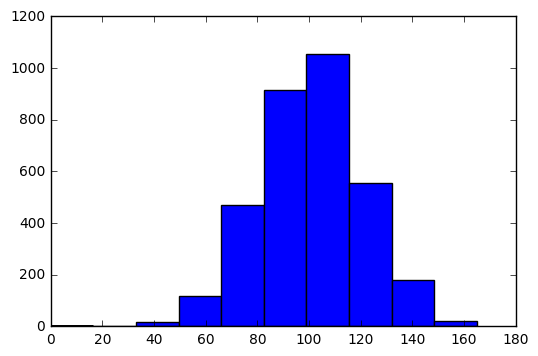

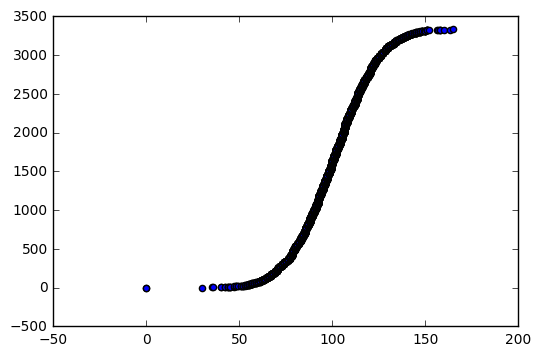



Eve Mins


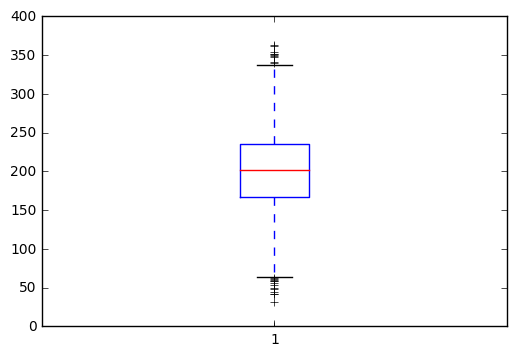

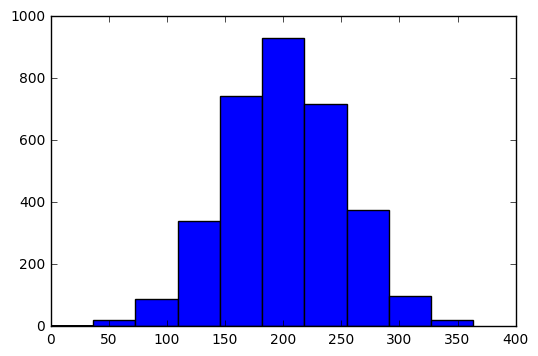

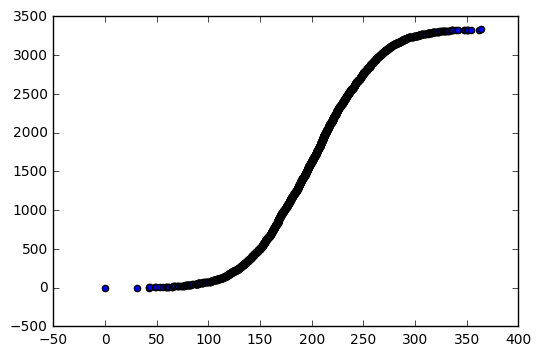



Eve Calls


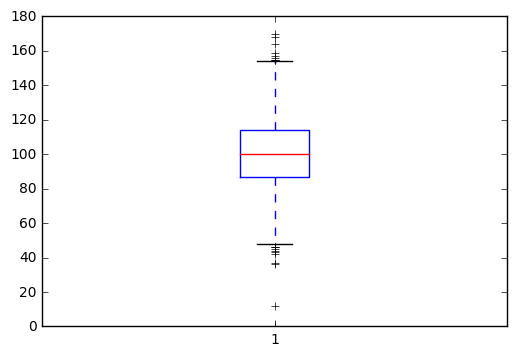

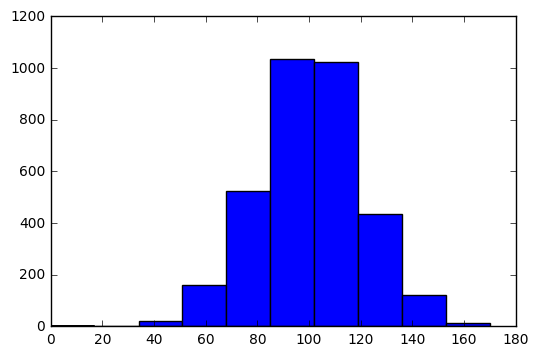

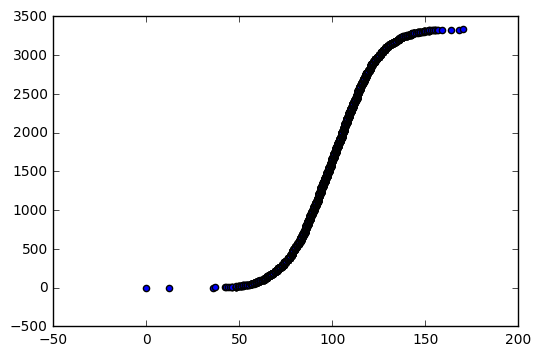



Night Mins


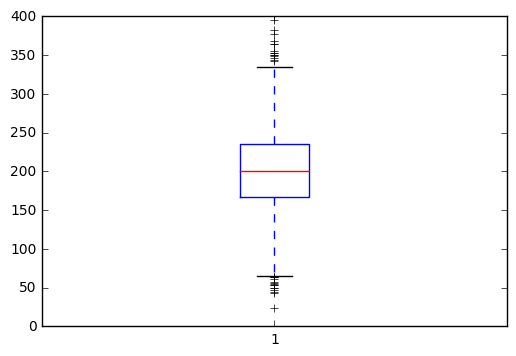

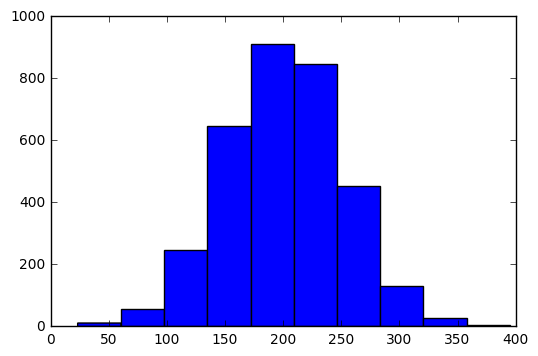

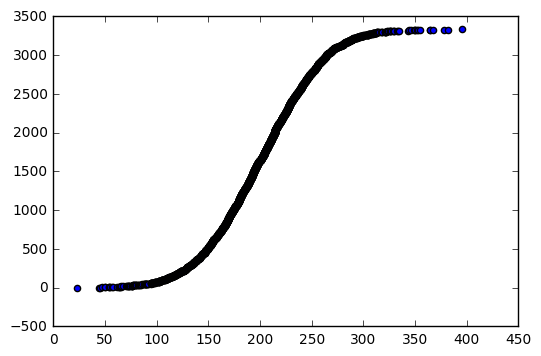



Night Calls


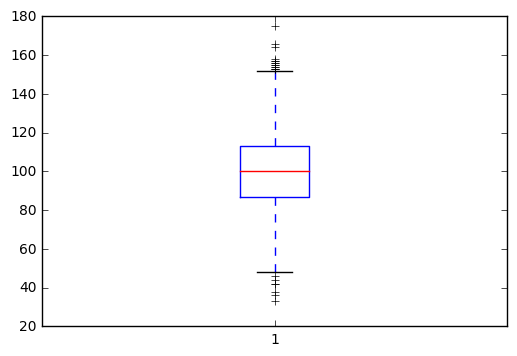

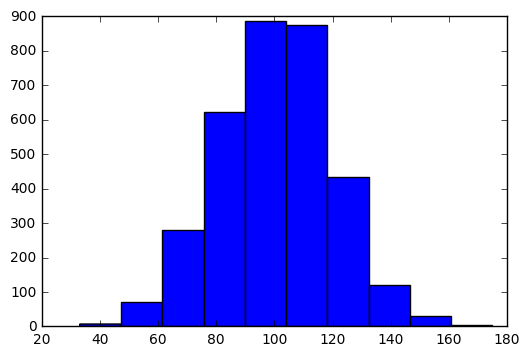

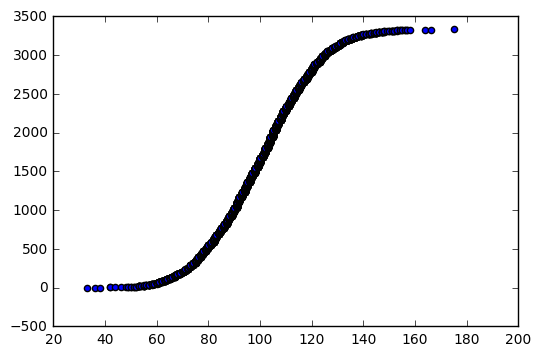



Intl Mins


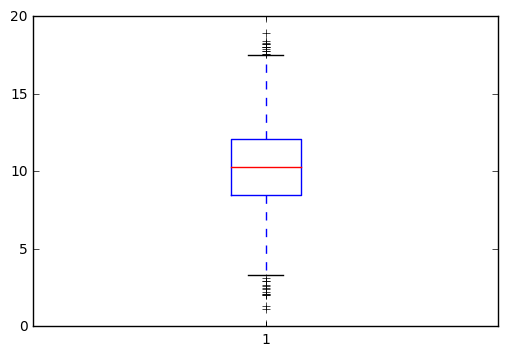

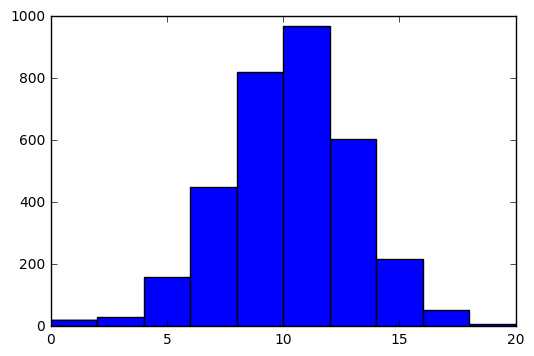

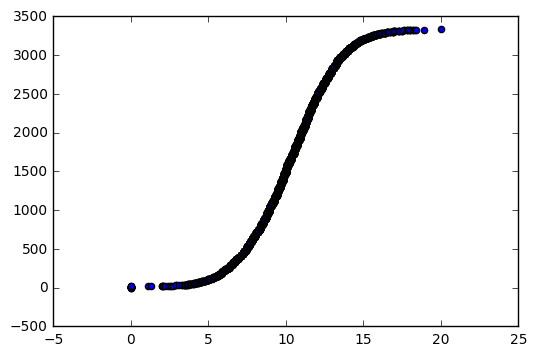



Intl Calls


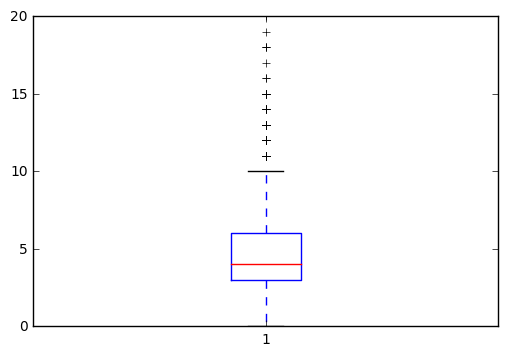

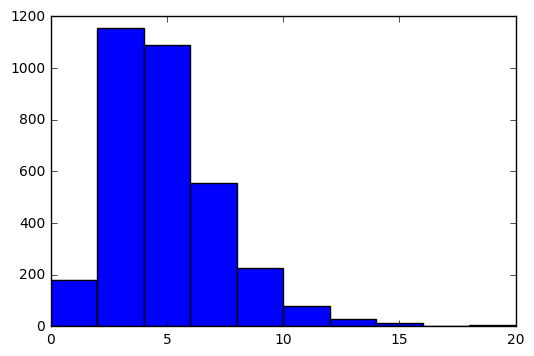

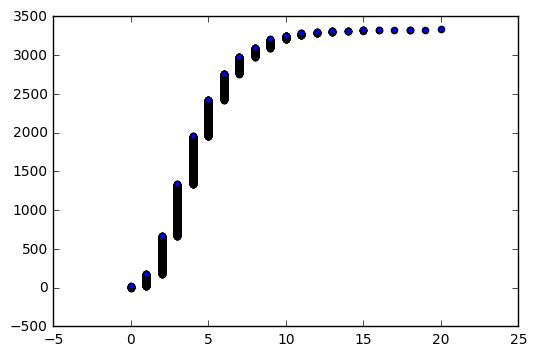



CustServ Calls


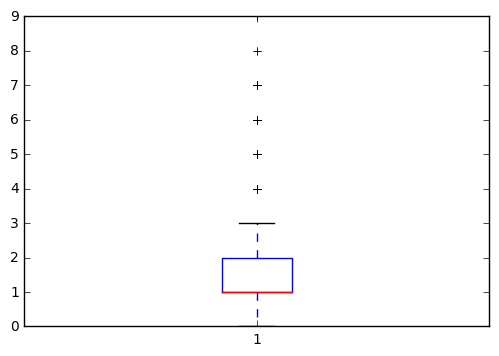

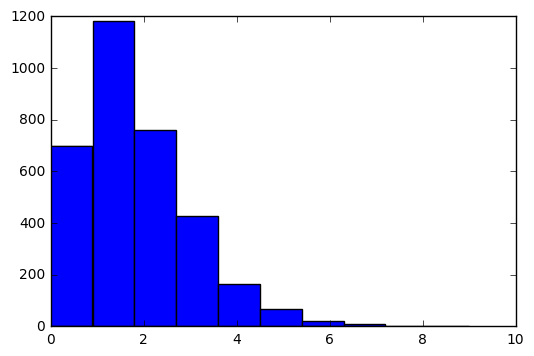

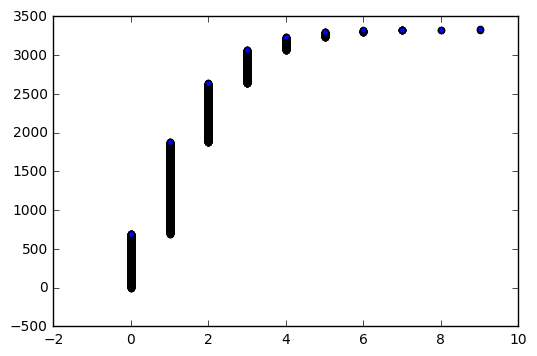

In [10]:
for v in continuous_v:
    print v
    
    # Boxplot
    plt.boxplot(np.array(df[v].dropna()))
    plt.show()
    
    # Histogram
    plt.hist(np.array(df[v].dropna()))
    plt.show()

    # Scatter plot
    x = np.array(df[v])
    x.sort()
    y = range(len(x))
    plt.scatter(x, y)
    plt.show()
    
    print '\n'

## Outlier detection

In [11]:
# Outlier detection

outliers_list = []
a = np.empty(0)

for v in continuous_v:

    no_outliers_idx = df[np.abs(df[v]-df[v].mean())<=(3*df[v].std())].index
    outliers_idx = np.array(df[~(np.abs(df[v]-df[v].mean())<=(3*df[v].std()))].index)
    a = np.concatenate((a, outliers_idx))

    print v, 'outliers:', len(outliers_idx)

all_outliers_idx = np.unique(a)
print '\nTotal outliers:', round(len(all_outliers_idx)/float(len(df))*100, 1), '% of the whole dataset'

Account Length outliers: 7
VMail Message outliers: 3
Day Mins outliers: 9
Day Calls outliers: 9
Eve Mins outliers: 9
Eve Calls outliers: 7
Night Mins outliers: 11
Night Calls outliers: 6
Intl Mins outliers: 22
Intl Calls outliers: 50
CustServ Calls outliers: 35

Total outliers: 4.9 % of the whole dataset


In [12]:
# Drop the outliers
df.drop(all_outliers_idx, inplace=True)

# Feature extraction

In [13]:
# New features

# Total mins / calls / charge
df['total_mins'] = df['Day Mins'] + df['Eve Mins'] + df['Night Mins'] + df['Intl Mins']
df['total_calls'] = df['Day Calls'] + df['Eve Calls'] + df['Night Calls'] + df['Intl Calls'] + df['CustServ Calls']
#df['total_charge'] = df['Day Charge'] + df['Eve Charge'] + df['Night Charge'] + df['Intl Charge']

# Region
W = ['WA', 'OR', 'ID', 'MT', 'WY', 'CO', 'UT', 'NV', 'CA', 'AZ', 'NM', 'HI','AK']
C = ['ND', 'SD', 'NE', 'KS', 'MO', 'IA', 'MN', 'WI', 'MI', 'IL', 'IN', 'OH', 'WV']
S = ['TX', 'OK', 'AR', 'LA', 'MS', 'KY', 'TN', 'AL', 'GA', 'SC', 'VA', 'NC', 'FL']
NE = ['PA', 'NY', 'VT', 'ME', 'NH', 'MA', 'RI', 'CT', 'NJ', 'DE', 'MD', 'DC']

df['region'] = ''
df.loc[df['State'].isin(W), 'region'] = 'W'
df.loc[df['State'].isin(C), 'region'] = 'C'
df.loc[df['State'].isin(S), 'region'] = 'S'
df.loc[df['State'].isin(NE), 'region'] = 'NE'

# From categorical variables to dummies

v = 'Area Code'
dummies = pd.get_dummies(df[v], prefix='area_code')
df = pd.concat([df, dummies], axis=1)

v = 'State'
dummies = pd.get_dummies(df[v], prefix='state')
df = pd.concat([df, dummies], axis=1)

v = 'region'
dummies = pd.get_dummies(df[v], prefix='region')
df = pd.concat([df, dummies], axis=1)

v = 'Churn?'
dummies_numpy = np.where(df[v]=='True.',1.,0.)
df['churn'] = dummies_numpy

v = 'VMail Plan'
dummies_numpy = np.where(df[v]=='yes',1.,0.)
df['vmail_plan'] = dummies_numpy

v = "Int'l Plan"
dummies_numpy = np.where(df[v]=='yes',1.,0.)
df['intl_plan'] = dummies_numpy

# Drop categorical variables
df.drop(categorical_v + ['region'], axis=1, inplace=True)

# Head after changes
print_full(df.head())

,Account Length,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,total_mins,total_calls,area_code_408,area_code_415,area_code_510,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,region_C,region_NE,region_S,region_W,churn,vmail_plan,intl_plan
0,128,25,265.1,110,197.4,99,244.7,91,10.0,3,1,717.2,304,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,107,26,161.6,123,195.5,103,254.4,103,13.7,3,1,625.2,333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,137,0,243.4,114,121.2,110,162.6,104,12.2,5,0,539.4,333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,84,0,299.4,71,61.9,88,196.9,89,6.6,7,2,564.8,257,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,75,0,166.7,113,148.3,122,186.9,121,10.1,3,3,512.0,362,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


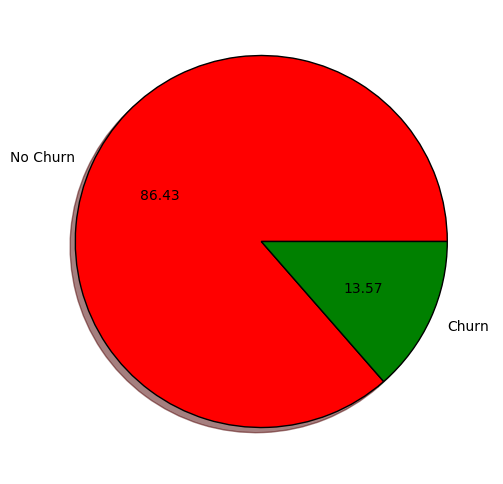

In [14]:
# Define X and y
df_X = df.drop('churn', axis=1)
X = df_X.as_matrix().astype(np.float)
y = np.array(df['churn'])

# Split in train and test
X2, X_test, y2, y_test = cross_validation.train_test_split(X, y, train_size=0.8, random_state=42)

# Pie plot
plt.pie(np.c_[len(y2)-np.sum(y2),np.sum(y2)][0],labels=['No Churn','Churn'],colors=['r','g'],shadow=True,autopct ='%.2f' )
fig = plt.gcf()
fig.set_size_inches(6,6)

# Feature Selection

## Score function: Chi2

In [15]:
# Select K best
skb = feature_selection.SelectKBest(score_func=feature_selection.chi2)
skb.fit(X2, y2)

# Feature selection table
df_fs = pd.DataFrame()
df_fs['feature'] = df_X.columns
df_fs['score'] = skb.scores_
df_fs['pvalue'] = skb.pvalues_
df_fs['p_value < 0.10'] = df_fs['pvalue'] < 0.10
df_fs['p_value < 0.05'] = df_fs['pvalue'] < 0.05
df_fs['p_value < 0.01'] = df_fs['pvalue'] < 0.01

In [16]:
# Best features table
df_bf = df_fs.sort_values('score', ascending=False).loc[df_fs['p_value < 0.10'] == True]
display(df_bf)

# Best features indexes
bf_idx = df_bf.index
print bf_idx

# Best feature X matrix
bf_X2 = X2[:, bf_idx]

,feature,score,pvalue,p_value < 0.10,p_value < 0.05,p_value < 0.01
2,Day Mins,2379.747853,0.000000e+00,True,True,True
11,total_mins,1829.409563,0.000000e+00,True,True,True
1,VMail Message,513.470829,1.114466e-113,True,True,True
4,Eve Mins,331.109823,5.508934e-74,True,True,True
72,intl_plan,161.051972,6.665146e-37,True,True,True
10,CustServ Calls,74.475771,6.138708e-18,True,True,True
6,Night Mins,73.185546,1.180169e-17,True,True,True
71,vmail_plan,20.829681,5.019896e-06,True,True,True
9,Intl Calls,10.721101,1.059206e-03,True,True,True
47,state_NJ,7.895181,4.956667e-03,True,True,True


Int64Index([ 2, 11,  1,  4, 72, 10,  6, 71,  9, 47, 49,  0, 68, 36, 20, 19, 17,
            61,  8, 27, 63, 41, 28, 67, 59, 57, 16],
           dtype='int64')


## Score function: ANOVA F-value

In [17]:
# Select K best
skb2 = feature_selection.SelectKBest()
skb2.fit(X2, y2)

# Feature selection table
df_fs2 = pd.DataFrame()
df_fs2['feature'] = df_X.columns
df_fs2['score'] = skb2.scores_
df_fs2['pvalue'] = skb2.pvalues_
df_fs2['p_value < 0.10'] = df_fs2['pvalue'] < 0.10
df_fs2['p_value < 0.05'] = df_fs2['pvalue'] < 0.05
df_fs2['p_value < 0.01'] = df_fs2['pvalue'] < 0.01

# Best features table
df_bf2 = df_fs2.sort_values('score', ascending=False).loc[df_fs2['p_value < 0.10'] == True]
display(df_bf2)

# Best features indexes
bf_idx2 = df_bf2.index
print bf_idx2

# Best feature X matrix
bf_X2_2 = X2[:, bf_idx2]

,feature,score,pvalue,p_value < 0.10,p_value < 0.05,p_value < 0.01
72,intl_plan,191.527981,4.807768e-42,True,True,True
2,Day Mins,157.062365,5.298558e-35,True,True,True
11,total_mins,145.468320,1.304376e-32,True,True,True
10,CustServ Calls,78.801383,1.271192e-18,True,True,True
71,vmail_plan,28.987167,7.955486e-08,True,True,True
4,Eve Mins,26.534026,2.788646e-07,True,True,True
1,VMail Message,22.339315,2.409855e-06,True,True,True
9,Intl Calls,10.140462,1.468106e-03,True,True,True
47,state_NJ,8.096213,4.471433e-03,True,True,True
68,region_NE,8.071689,4.532153e-03,True,True,True


Int64Index([72,  2, 11, 10, 71,  4,  1,  9, 47, 68, 49,  8,  6, 36, 17, 61, 19,
            20, 67, 27, 63, 41, 28, 59, 57, 16],
           dtype='int64')


## Score function: Tree-based feature selection

In [18]:
# Tree-based feature selection
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=500, max_depth=20,
                              random_state=None)

forest.fit(X2, y2)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

df_fs3 = pd.DataFrame()
df_fs3['feature'] = df_X.columns
df_fs3['importance'] = importances

n = max(len(bf_idx), len(bf_idx2))
df_bf3 = df_fs3.sort_values('importance', ascending = False)[:n]
display(df_bf3)

# Best features indexes
bf_idx3 = df_bf3.index
print bf_idx3

# Best feature X matrix
bf_X2_3 = X2[:, bf_idx3]

,feature,importance
2,Day Mins,0.126045
11,total_mins,0.113530
10,CustServ Calls,0.088411
72,intl_plan,0.087543
9,Intl Calls,0.042595
4,Eve Mins,0.042223
8,Intl Mins,0.040395
6,Night Mins,0.033613
3,Day Calls,0.033135
12,total_calls,0.032494


Int64Index([ 2, 11, 10, 72,  9,  4,  8,  6,  3, 12,  7,  5,  0, 71,  1, 15, 14,
            13, 49, 47, 68, 67, 69, 70, 59, 41, 36],
           dtype='int64')


In [20]:
rfc = ensemble.RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_leaf=1, random_state=42)

clf_list = [rfc]

bf_m = nested_k_fold_CV(bf_X2, y2, 5, 10, clf_list, 'roc_auc')
bf_m2 = nested_k_fold_CV(bf_X2_2, y2, 5, 10, clf_list, 'roc_auc')
bf_m3 = nested_k_fold_CV(bf_X2_3, y2, 5, 10, clf_list, 'roc_auc')
af_m = nested_k_fold_CV(X2, y2, 5, 10, clf_list, 'roc_auc')

m_array = np.concatenate((bf_m.T, bf_m2.T, bf_m3.T, af_m.T))

1. Best features (Chi2)
2. Best features (ANOVA F-value)
3. Best Features (ExtraTreesClassifier)
4. All features


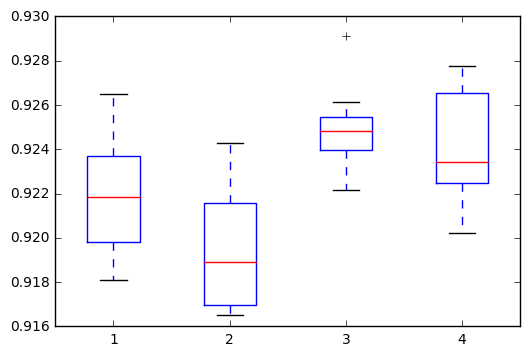

In [21]:
# Box plot
print '1. Best features (Chi2)\n2. Best features (ANOVA F-value)\n3. Best Features (ExtraTreesClassifier)\n4. All features'
plt.boxplot(m_array.T)
plt.show()

It looks like ExtraTreesClassifier is the feature selection method with best results.

# Grid search

## K Nearest Neighbours

In [19]:
# Choose a classifier
knn = neighbors.KNeighborsClassifier()
clf = knn

# Choose the parameters and its values
knn_p = {'weights':('uniform', 'distance'), 'n_neighbors':[1, 5, 10, 100, 200, 500]}

parameters = knn_p

# Grid search
gs = grid_search.GridSearchCV(clf, parameters, scoring='roc_auc', n_jobs=-1, cv=5)
gs.fit(bf_X2_3, y2)

# Best parameters
gs.best_params_

{'n_neighbors': 200, 'weights': 'uniform'}

## Logistic Regression

In [20]:
# Choose a classifier
lr = linear_model.LogisticRegression()
clf = lr

# Choose the parameters and its values
lr_p = {'penalty':('l1', 'l2'), 'C':[0.1, 0.5, 1, 1.5, 2, 10, 20, 50, 100, 200]}

parameters = lr_p

# Grid search
gs = grid_search.GridSearchCV(clf, parameters, scoring='roc_auc', n_jobs=-1, cv=5)
gs.fit(bf_X2_3, y2)

# Best parameters
gs.best_params_

{'C': 10, 'penalty': 'l2'}

## Random Forest

In [21]:
# Choose a classifier
rfc = ensemble.RandomForestClassifier()
clf = rfc

# Choose the parameters and its values
rfc_p = {'n_estimators': [10, 100, 500], 
         'max_depth': [10, 20, None], 
         'min_samples_leaf': [1, 5, 10]}

parameters = rfc_p

# Grid search
gs = grid_search.GridSearchCV(clf, parameters, scoring='roc_auc', n_jobs=-1, cv=5)
gs.fit(bf_X2_3, y2)

# Best parameters
gs.best_params_

{'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 500}

## Support Vector Machine

In [22]:
# Choose a classifier
svm_clf = svm.SVC()
clf = svm_clf

# Choose the parameters and its values
svm_p = {'C': [1, 10], 
         'kernel': ['linear', 'rbf'], 
         'gamma': [0.001, 'auto']}

parameters = svm_p

# Grid search
gs = grid_search.GridSearchCV(clf, parameters, scoring='roc_auc', n_jobs=-1, cv=5, verbose=1)
#gs.fit(bf_X2_3, y2)

# Never finishs and kills the kernel...

# Best parameters
#gs.best_params_

In [22]:
# Parameter optimized classifiers
rfc = ensemble.RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_leaf=1, random_state=42)
lr = linear_model.LogisticRegression(penalty='l2', C=10)
knn = neighbors.KNeighborsClassifier(n_neighbors=200, weights='uniform')
svm_clf = svm.SVC(probability=True)

# Validation methods

## Simple train and validation split

In [23]:
# Split in train and validation
X_train, X_valid, y_train, y_valid = cross_validation.train_test_split(bf_X2_3, y2, train_size=0.625, random_state=42)
print 'X_train length:', len(X_train), '(', round(len(X_train)/float(len(df))*100), '%)'
print 'X_valid length:', len(X_valid), '(', round(len(X_valid)/float(len(df))*100), '%)'
print 'X_test length:', len(X_test), '(', round(len(X_test)/float(len(df))*100), '%)'

X_train length: 1584 ( 50.0 %)
X_valid length: 951 ( 30.0 %)
X_test length: 634 ( 20.0 %)


In [24]:
# Determine the classifier
clf = rfc

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Fit the classifier
clf.fit(X_train_scaled, y_train)

# Validate the classifier
X_valid_scaled = scaler.transform(X_valid)
score = clf.predict_proba(X_valid_scaled)[:, 1].reshape(-1,1)
yhat = clf.predict(X_valid_scaled).reshape(-1,1)

# Get metrics
m = get_metrics(y_valid, score, yhat)
print m

{'log_loss': 0.19460770907258307, 'roc_auc': 0.90055349062702006, 'accuracy': 0.94637223974763407}


## K-fold Cross validation

{'log_loss': 0.18717928101478115, 'roc_auc': 0.92497452580854023, 'accuracy': 0.9570019723865878}


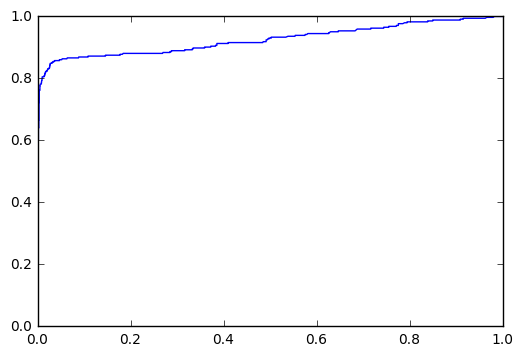

In [25]:
# Determine the classifier
clf = rfc

# K-fold cross validation
score, yhat = k_fold_cross_validation(bf_X2_3, y2, 5, rfc, random_state=42)

# Get metrics
m = get_metrics(y2, score, yhat)
print m

# This is the ROC curve
fpr, tpr, _ = metrics.roc_curve(y2, score)
plt.plot(fpr, tpr)
plt.show() 

## Nested cross validation

In [26]:
# Choose the classifiers
clf_list = [rfc, lr, knn, svm_clf]

# Choose the metric
metric = 'roc_auc'

# Number of CVs
n = 10

# Nested K fold cross validation
metric_array = nested_k_fold_CV(bf_X2_3, y2, 5, 10, clf_list, 'roc_auc')

1 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False) 

2 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

3 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=200, p=2,
           weights='uniform') 

4 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbos

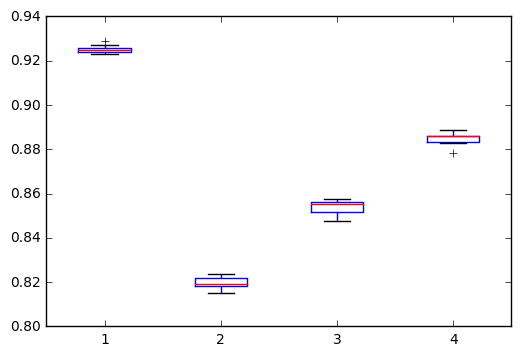

In [27]:
# Print classifiers
clf_num = 1
for i in clf_list:
    print clf_num, i, '\n'
    clf_num += 1

# Box plot
plt.boxplot(metric_array)
plt.show()

# Test set evaluation

In [28]:
# Best feature X_test matrix
bf_X_test = X_test[:, bf_idx3]

# Determine the classifier
best_clf = rfc

# Scale data
scaler = StandardScaler()
X2_scaled = scaler.fit_transform(bf_X2_3)

# Fit the classifier
best_clf.fit(X2_scaled, y2)

# Validate the classifier
X_test_scaled = scaler.transform(bf_X_test)
score = best_clf.predict_proba(X_test_scaled)[:, 1].reshape(-1,1)
yhat = best_clf.predict(X_test_scaled).reshape(-1,1)

# Get metrics
get_metrics(y_test, score, yhat)

{'accuracy': 0.94952681388012616,
 'log_loss': 0.21944850572847283,
 'roc_auc': 0.89682645446238196}